Spam Sms Detection 

In this project we will build a machine learning model to classify SMS messages as spam or ham (not spam).

**Steps**
1)Load and Explore the dataset
2)Preprocess the text
3)Train ML models
4)Evalute the model
5)Build a prediction function


In [1]:
#Import the necessary libraries
# !pip install pandas numpy scikit-learn matplotlib seaborn nltk wordcloud joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import joblib

import nltk
# Run once (you can comment these out after first run if already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

from text_cleaner import preprocess_text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
Data_path = r'C:\Users\KIIT\OneDrive\Desktop\Data Science\Projects\Sms_Detection\data\Spam_SMS.csv'

df = pd.read_csv(Data_path)
print(df.columns)
df.head()


Index(['Class', 'Message'], dtype='object')


,Class,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df = df.rename(columns={'Class': 'label','Message':'text'})
df[['label','text']].head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#Cleaning the Data

#removing null values
df  = df.dropna(subset=['label','text'])

#make sure the text is string
df['text'] = df['text'].astype(str)

df['label'] = df['label'].str.lower().str.strip()

df.shape

(5574, 2)

In [5]:
df['label'].value_counts()

ham     4827
spam     747
Name: label, dtype: int64

In [6]:
extra_spam_texts = [
    "You have been selected to earn $5000 per week working from home. No investment required. Call now!",
    "Earn $5000 per week from home with no investment required.",
    "Make money fast from home. Start earning today with zero investment.",
    "Exclusive offer: Earn $300 per day from home. Limited time only.",
    "Guaranteed income from home. No experience or investment needed.",
    "Turn your phone into a money making machine. Start earning cash today.",
    "Get an instant loan with no documents required. Apply now.",
    "Pre-approved loan available for you. Click to receive your funds.",
    "Your bank account will be suspended. Verify your bank details immediately.",
    "URGENT: Your account has been blocked. Confirm your banking information now.",
    "FINAL WARNING: Your account will be closed today if you do not verify your details.",
    "Your ATM card has been blocked. Call this number to unblock immediately.",
    "Win real cash by working from home. Limited seats, join now!",
    "Get rich quickly with our proven investment system. No risk, big profit.",
    "You are eligible for a high-income work-from-home job. Apply now.",
    "Receive daily payments straight into your bank account. Join today.",
    "Your number has been chosen for a premium investment opportunity.",
    "Start earning unlimited income online with no upfront payment.",
    "Congratulations! You qualify for a profit-sharing work-from-home plan.",
    "Get paid daily for simple online tasks. No skills required."
]

extra_df = pd.DataFrame({
    'label': ['spam'] * len(extra_spam_texts),
    'text': extra_spam_texts
})

df_augmented = pd.concat([df, extra_df], ignore_index=True)

print("Original labels:\n", df['label'].value_counts())
print("\nAfter augmentation:\n", df_augmented['label'].value_counts())


Original labels:
 ham     4827
spam     747
Name: label, dtype: int64

After augmentation:
 ham     4827
spam     767
Name: label, dtype: int64


Text(0, 0.5, 'Count')

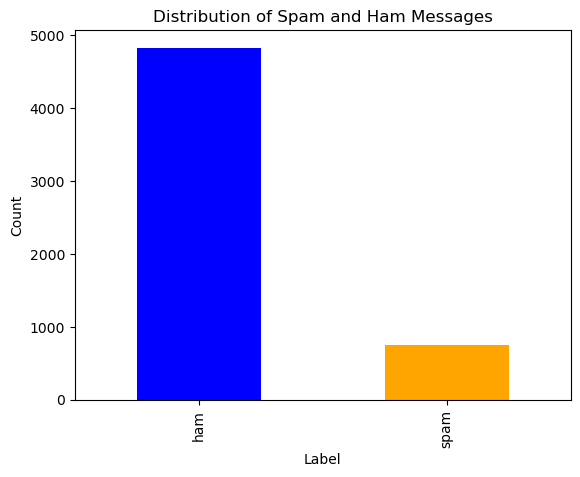

In [7]:
color = ['blue', 'orange']
df['label'].value_counts().plot(kind='bar',color=color)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')

In [8]:
#Message length

df['text_length'] = df['text'].apply(len)
df[['label','text_length']].groupby('label').describe()

text_length                                                         
            count        mean        std   min    25%    50%    75%    max
label                                                                     
ham        4827.0   71.440232  58.321812   2.0   33.0   52.0   93.0  910.0
spam        747.0  138.634538  28.854103  13.0  133.0  149.0  157.0  223.0

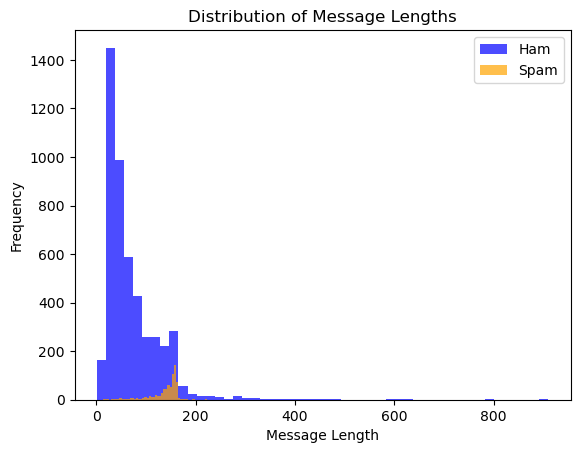

In [9]:
plt.hist(df[df['label']== 'ham']['text_length'],bins=50,alpha=0.7,label='Ham',color='blue')
plt.hist(df[df['label']=='spam']['text_length'],bins=50,alpha=0.7,label='Spam',color='orange')
plt.legend()
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

In [10]:
X = df_augmented['text']
y = df_augmented['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

vectorizer_adv = TfidfVectorizer(
    tokenizer=preprocess_text,  # from text_cleaner.py
    token_pattern=None,         # required for custom tokenizer
    lowercase=False,            # we lowercase inside preprocess_text
    ngram_range=(1, 2),
    min_df=2
)

X_train_vec_adv = vectorizer_adv.fit_transform(X_train)
X_test_vec_adv  = vectorizer_adv.transform(X_test)

X_train_vec_adv.shape, X_test_vec_adv.shape



((4475, 5628), (1119, 5628))

In [ ]:
# Train SVM classifier with class_weight='balanced'
svm_clf = LinearSVC(class_weight='balanced')
svm_clf.fit(X_train_vec_adv, y_train)

y_pred_svm = svm_clf.predict(X_test_vec_adv)

print("SVM accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM accuracy: 0.9794459338695264
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.92      0.92       153

    accuracy                           0.98      1119
   macro avg       0.96      0.95      0.96      1119
weighted avg       0.98      0.98      0.98      1119



c:\Users\KIIT\anaconda3\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


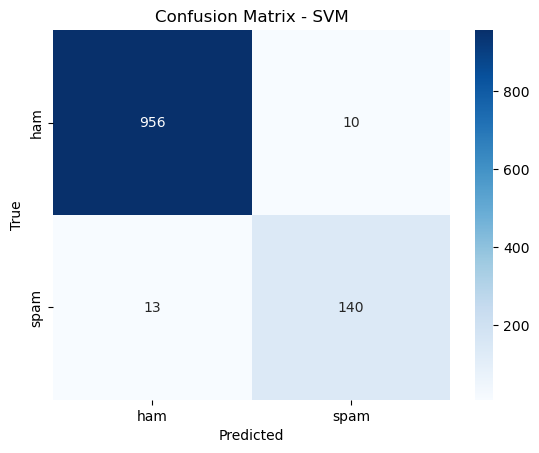

In [12]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham', 'spam'],
            yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.show()


In [23]:

PATTERN_GROUPS = {
    "financial": {
        "patterns": [
            r"\bearn\b.{0,20}\b\d{2,}\b",              # earn 5000, earn 10000
            r"\bwork\s+from\s+home\b",
            r"\bmake\s+money\b",
            r"\bextra\s+income\b",
            r"\bno\s+investment\b",
        ],
        "priority": 3,   # high
        "min_hits": 1,
    },
    "loan_credit": {
        "patterns": [
            r"\binstant\s+loan\b",
            r"\bpre[- ]?approved\s+loan\b",
            r"\bno\s+document[s]?\b",
            r"\blower\s+interest\b",
        ],
        "priority": 2,   # medium
        "min_hits": 1,
    },
    "phishing": {
        "patterns": [
            r"\byour\s+account\b.{0,20}\b(suspended|blocked|closed)\b",
            r"\bverify\b.{0,15}\b(bank|account|card|details)\b",
            r"\bconfirm\b.{0,15}\b(pin|otp|password)\b",
        ],
        "priority": 3,   # high
        "min_hits": 1,
    },
    "lottery_prize": {
        "patterns": [
            r"\bcongratulation(?:s)?\b.{0,20}\b(won|winner)\b",
            r"\bfree\b\s+(gift|prize|entry|voucher|ticket)\b",
            r"\bselected\b.{0,20}\b(lucky|winner)\b",
        ],
        "priority": 2,   # medium
        "min_hits": 1,
    },
    "generic_promo": {
        "patterns": [
            r"\blimited\s+time\s+offer\b",
            r"\bclick\s+the\s+link\b",
            r"\bcall\s+now\b",
            r"\bact\s+now\b",
        ],
        "priority": 1,   # low
        "min_hits": 2,   # require more than one to be sure
    },
}


In [24]:
def analyze_rule_matches(text: str):
    """
    Returns:
      - group_hits: dict[group_name] = number of pattern matches in that group
      - total_score: sum(priority * hits) over all groups
      - matched_details: list of (group, pattern) for debugging/explanations
    """
    t = text.lower()
    group_hits = {}
    matched_details = []
    total_score = 0

    for group_name, cfg in PATTERN_GROUPS.items():
        patterns = cfg["patterns"]
        priority = cfg["priority"]
        hits_in_group = 0

        for pat in patterns:
            if re.search(pat, t):
                hits_in_group += 1
                matched_details.append((group_name, pat))

        if hits_in_group > 0:
            group_hits[group_name] = hits_in_group
            total_score += hits_in_group * priority

    return group_hits, total_score, matched_details


In [26]:
def is_rule_based_spam(text: str) -> (bool, dict, int):
    """
    Decide if text is spam based on grouped patterns.

    Returns:
      is_spam (bool),
      group_hits (dict),
      total_score (int)
    """
    group_hits, total_score, matched_details = analyze_rule_matches(text)

    # Hard conditions based on groups
    for group_name, hits in group_hits.items():
        cfg = PATTERN_GROUPS[group_name]
        priority = cfg["priority"]
        min_hits = cfg["min_hits"]

        # If a high-priority group hits enough times -> spam
        if priority >= 3 and hits >= min_hits:
            return True, group_hits, total_score

        # For medium priority, require at least min_hits (usually 1)
        if priority == 2 and hits >= min_hits:
            return True, group_hits, total_score

    # For low-priority generic promo, we could require more hits or a score threshold
    # Example: if generic_promo appears AND total_score is high enough
    if "generic_promo" in group_hits and total_score >= 3:
        return True, group_hits, total_score

    # Or you can add a global safety net:
    # if total_score >= 4:
    #     return True, group_hits, total_score

    return False, group_hits, total_score


In [27]:
def classify_message(text: str, return_explanation: bool = False):
    """
    Final classifier:
      1. Run rule engine (grouped patterns).
      2. If rules say spam -> spam (with rule explanation).
      3. Else -> use SVM model.

    If return_explanation=True, also returns a dict explaining the decision.
    """
    is_spam_rule, group_hits, total_score = is_rule_based_spam(text)

    if is_spam_rule:
        label = "spam"
        explanation = {
            "via": "rules",
            "group_hits": group_hits,
            "total_score": total_score,
        }
    else:
        vec = vectorizer_adv.transform([text])
        label = svm_clf.predict(vec)[0]
        explanation = {
            "via": "model",
            "group_hits": group_hits,
            "total_score": total_score,
        }

    if return_explanation:
        return label, explanation
    return label


In [29]:
#Test with some examples

test_messages = [
    "You have been selected to earn $5000 per week working from home. No investment required. Call now!",
    "Congratulations! You have won a brand new iPhone 15. Click the link to claim your prize.",
    "Your account will be suspended. Verify your bank details immediately.",
    "Hey, are we still meeting for coffee tomorrow?",
    "Mom asked if you could bring some milk on your way back home."
]

for m in test_messages:
    label, expl = classify_message(m, return_explanation=True)
    print("Message:", m)
    print("Predicted:", label)
    print("Explanation:", expl)
    print("-" * 80)


Message: You have been selected to earn $5000 per week working from home. No investment required. Call now!
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'financial': 2, 'generic_promo': 1}, 'total_score': 7}
--------------------------------------------------------------------------------
Message: Congratulations! You have won a brand new iPhone 15. Click the link to claim your prize.
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'lottery_prize': 1, 'generic_promo': 1}, 'total_score': 3}
--------------------------------------------------------------------------------
Message: Your account will be suspended. Verify your bank details immediately.
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'phishing': 2}, 'total_score': 6}
--------------------------------------------------------------------------------
Message: Hey, are we still meeting for coffee tomorrow?
Predicted: ham
Explanation: {'via': 'model', 'group_hits': {}, 'total_score': 0}
----

NLP Visualization ( WordCloud and Most Common Words)

In [15]:
#Build token list for spam and ham using the same cleaner
spam_tokens = []
ham_tokens  = []

for text in df_augmented[df_augmented['label'] == 'spam']['text']:
    spam_tokens.extend(preprocess_text(text))

for text in df_augmented[df_augmented['label'] == 'ham']['text']:
    ham_tokens.extend(preprocess_text(text))

print("Sample spam tokens:", spam_tokens[:20])
print("Sample ham tokens:", ham_tokens[:20])



Sample spam tokens: ['free', 'entry', 'number', 'wkly', 'comp', 'final', 'tkts', 'number', 'number', 'text', 'number', 'receive', 'entry', 'question', 'rate', 'apply', 'number', 'number', 'freemsg', 'darling']
Sample ham tokens: ['jurong', 'point', 'crazy', 'available', 'bugis', 'great', 'world', 'buffet', 'cine', 'amore', 'joking', 'early', 'already', 'think', 'go', 'life', 'around', 'though', 'even', 'brother']


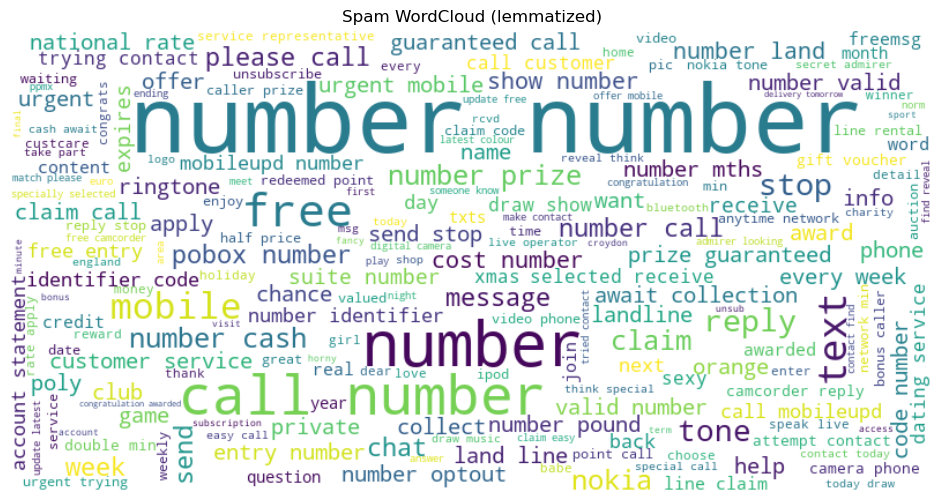

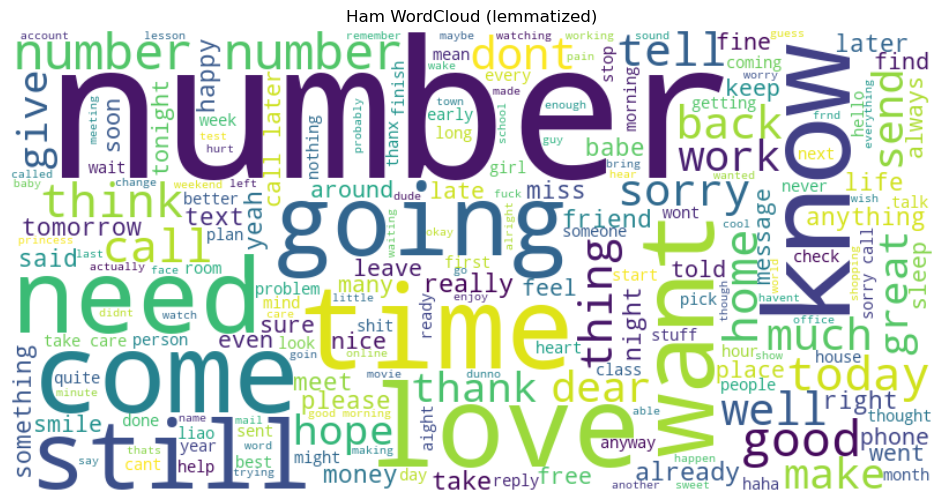

In [16]:
#WordClouds

spam_text_clean = " ".join(spam_tokens)
ham_text_clean  = " ".join(ham_tokens)

spam_wc = WordCloud(width=800, height=400, background_color='white').generate(spam_text_clean)
plt.figure(figsize=(12, 6))
plt.imshow(spam_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Spam WordCloud (lemmatized)")
plt.show()

ham_wc = WordCloud(width=800, height=400, background_color='white').generate(ham_text_clean)
plt.figure(figsize=(12, 6))
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Ham WordCloud (lemmatized)")
plt.show()


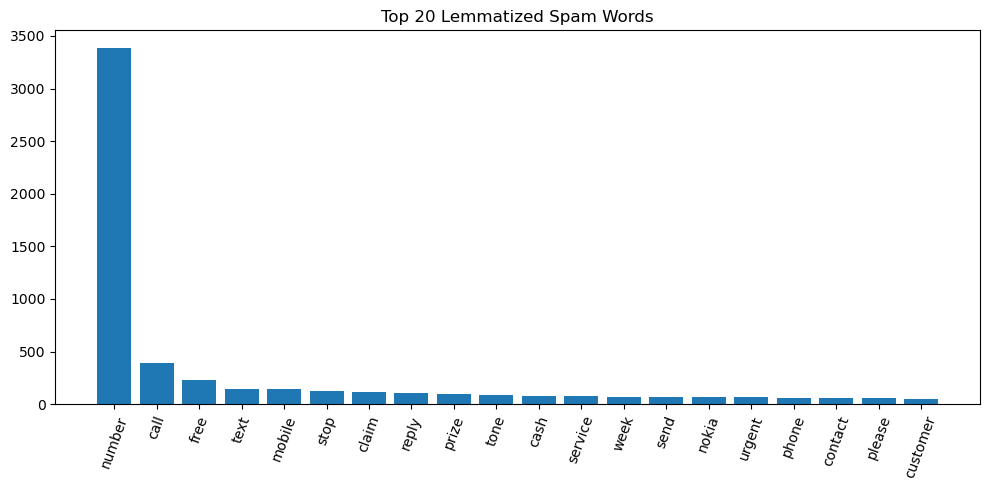

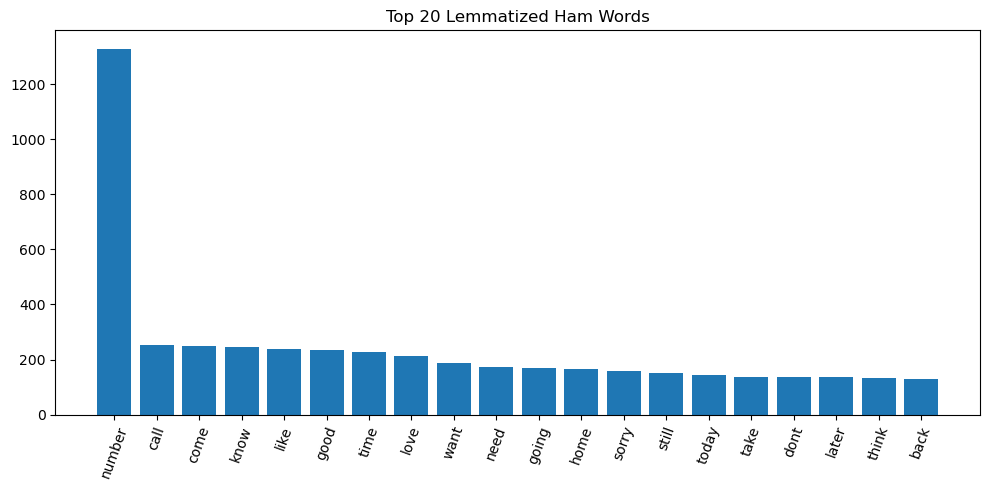

In [17]:
#Top 20 most common words in spam and ham
spam_common = Counter(spam_tokens).most_common(20)
ham_common  = Counter(ham_tokens).most_common(20)

words_spam, counts_spam = zip(*spam_common)
plt.figure(figsize=(10, 5))
plt.bar(words_spam, counts_spam)
plt.xticks(rotation=70)
plt.title("Top 20 Lemmatized Spam Words")
plt.tight_layout()
plt.show()

words_ham, counts_ham = zip(*ham_common)
plt.figure(figsize=(10, 5))
plt.bar(words_ham, counts_ham)
plt.xticks(rotation=70)
plt.title("Top 20 Lemmatized Ham Words")
plt.tight_layout()
plt.show()

In [18]:
os.makedirs("models", exist_ok=True)

joblib.dump(svm_clf, "models/spam_svm_model.pkl")
joblib.dump(vectorizer_adv, "models/tfidf_vectorizer_adv.pkl")

print("Saved SVM model and vectorizer.")


Saved SVM model and vectorizer.


In [30]:

svm_clf = joblib.load("models/spam_svm_model.pkl")
vectorizer_adv = joblib.load("models/tfidf_vectorizer_adv.pkl")
from text_cleaner import preprocess_text  # still needed for tokenizer consistency

test_messages = [
    # Very obvious spam
    "You have been selected to earn $5000 per week working from home. No investment required. Call now!",
    "Congratulations! You have won a brand new iPhone 15. Click the link to claim your prize.",
    "Your account will be suspended. Verify your bank details immediately.",
    "Get an instant loan approved in 5 minutes. No documents needed!",
    "Earn money fast by completing simple online tasks from home.",

    # Likely ham
    "Hey, are we still meeting for coffee tomorrow?",
    "Mom asked if you could bring some milk on your way back home.",
    "Don't forget we have an exam next week, start revising.",
    "Can you send me yesterday's class notes?",
    "I reached home safely, talk to you later."
]

for m in test_messages:
    label, expl = classify_message(m, return_explanation=True)
    print("Message:", m)
    print("Predicted:", label)
    print("Explanation:", expl)
    print("-" * 80)


Message: You have been selected to earn $5000 per week working from home. No investment required. Call now!
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'financial': 2, 'generic_promo': 1}, 'total_score': 7}
--------------------------------------------------------------------------------
Message: Congratulations! You have won a brand new iPhone 15. Click the link to claim your prize.
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'lottery_prize': 1, 'generic_promo': 1}, 'total_score': 3}
--------------------------------------------------------------------------------
Message: Your account will be suspended. Verify your bank details immediately.
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'phishing': 2}, 'total_score': 6}
--------------------------------------------------------------------------------
Message: Get an instant loan approved in 5 minutes. No documents needed!
Predicted: spam
Explanation: {'via': 'rules', 'group_hits': {'loan_c

In [33]:
def interact():
    while True:
        text = input("Enter a message or type 'quit' to exit")
        if text.lower() == 'quit':
            break
        label, expl = classify_message(text, return_explanation=True)
        print("Message:", text)
        print("Predicted:", label)
        print("Explanation:", expl)
        print("-" * 80)
        
interact()
        

Message: congrats for your new car
Predicted: ham
Explanation: {'via': 'model', 'group_hits': {}, 'total_score': 0}
--------------------------------------------------------------------------------
Message: are you free tonight! ,its your chance to earn some money 
Predicted: spam
Explanation: {'via': 'model', 'group_hits': {}, 'total_score': 0}
--------------------------------------------------------------------------------
